# GradCAM mapsVisualisation tutorial

In order to visualize GradCAM maps you need an architecture and at least one subject to generate filters for.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.viz import plot_topomap
from meegnet.network import Model, Flatten
from meegnet.dataloaders import Dataset
from pytorch_grad_cam import GradCAM
from meegnet.viz import plot_masked_epoch
import cv2
from PIL import Image

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Constants

In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
sensors = ["MAG", "PLANNAR1", "PLANNAR2"]
n_channels = len(sensors)
input_size = (n_channels, 102, 400)

n_outputs = 2 # using auditory vs visual stimulus classification -> 2 classes


# Setting up paths
save_path = "/home/arthur/data/"
viz_path = save_path

clf_type = "eventclf"

### Loading the model

We load the model. Using from_pretrained, we use the pre-trained model uploaded on huggingface. It is also possible to use a custom model using load and specifying a model path.

In [3]:
# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 41 

# net option can be "meegnet", "eegnet" etc, see documentation
net_option = "meegnet" 

# name of the model
name = f"eventclf_{net_option}_{seed}_{n_channels}"

my_model = Model(name, net_option, input_size, n_outputs, save_path=save_path)
my_model.from_pretrained()
# model_path = os.path.join(save_path, "net_42_fold1_MAG.pt")
# my_model.load(model_path)

net = my_model.net

### Loading data

Next we load data based on the data framework established in the prepare data tutorial. We choose to only load 100 subjects for demonstration purposes.

In [4]:
max_subj = 100

csv_file = os.path.join(save_path, f"participants_info.csv")
dataframe = (
    pd.read_csv(csv_file, index_col=0)
    .sample(frac=1, random_state=seed)
    .reset_index(drop=True)
)
subj_list = dataframe["sub"]

if max_subj is not None:
    subj_list = subj_list[:max_subj]

### Compute outputs for loaded data

We compute the Gradcam masks for each selected subject and trial, use the mask projected on the data to highlight where the gradients are the highest i.e., where the network considers most information is located for classification

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


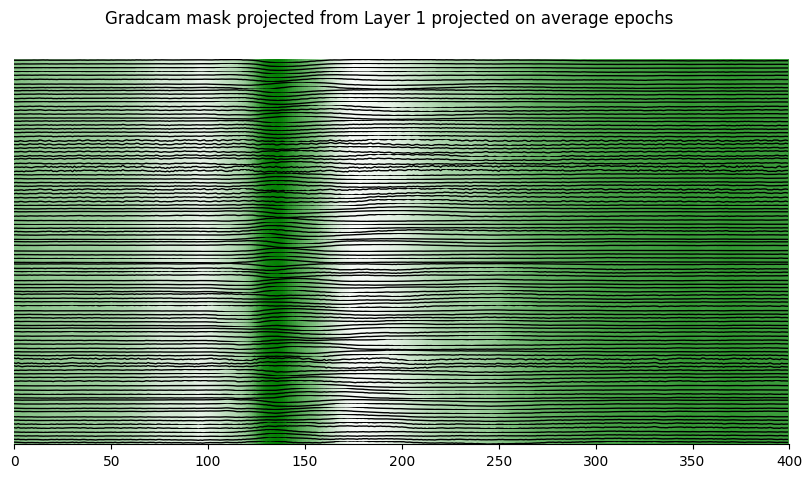

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


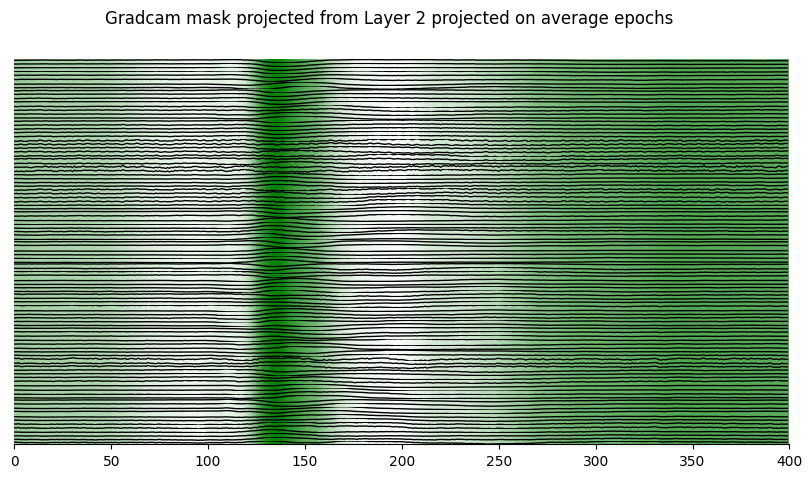

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


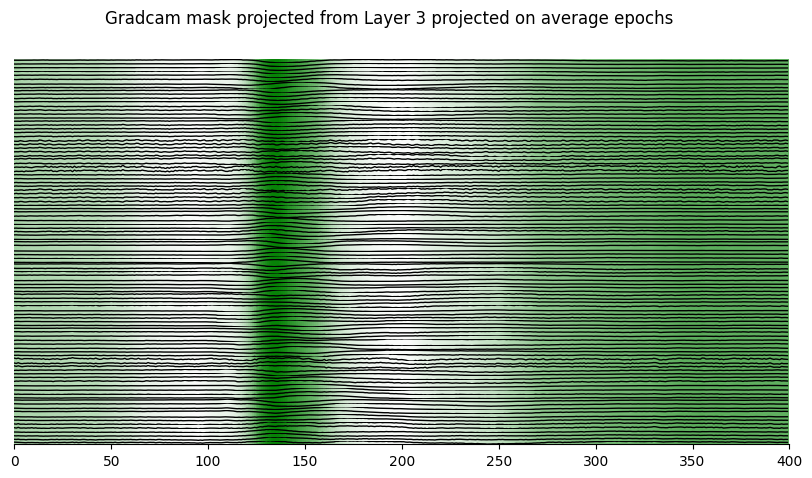

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


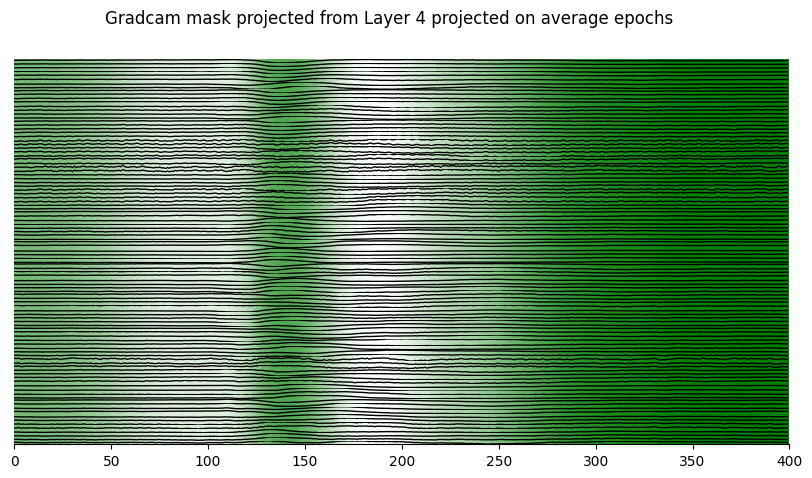

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


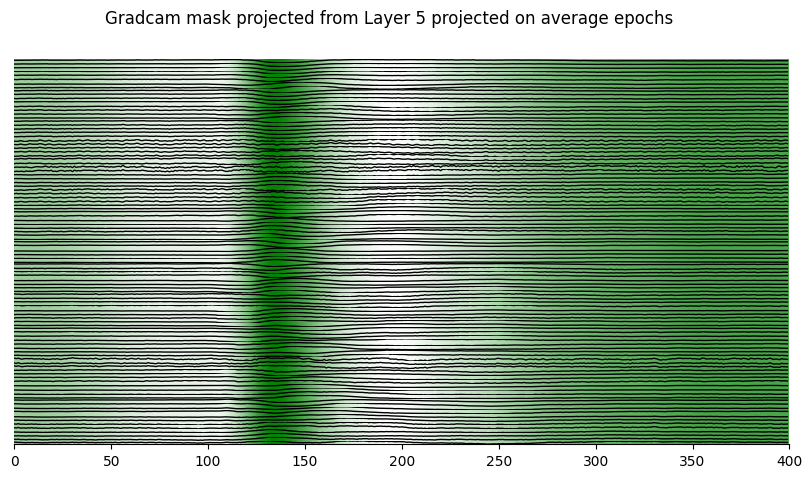

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


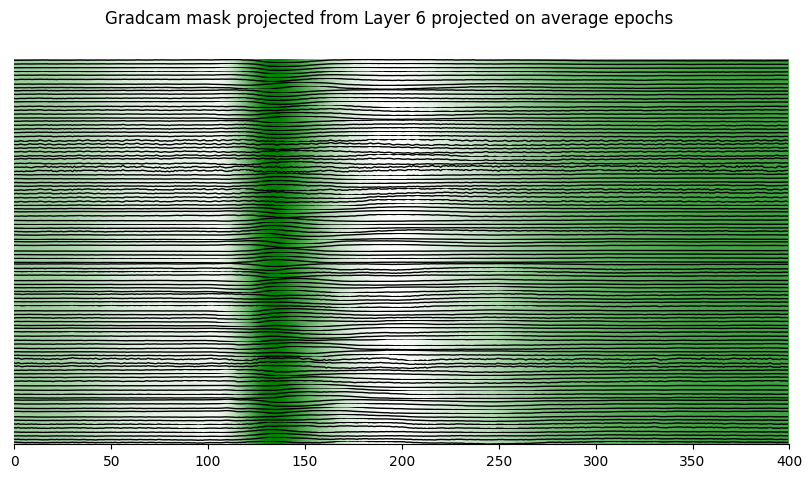

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


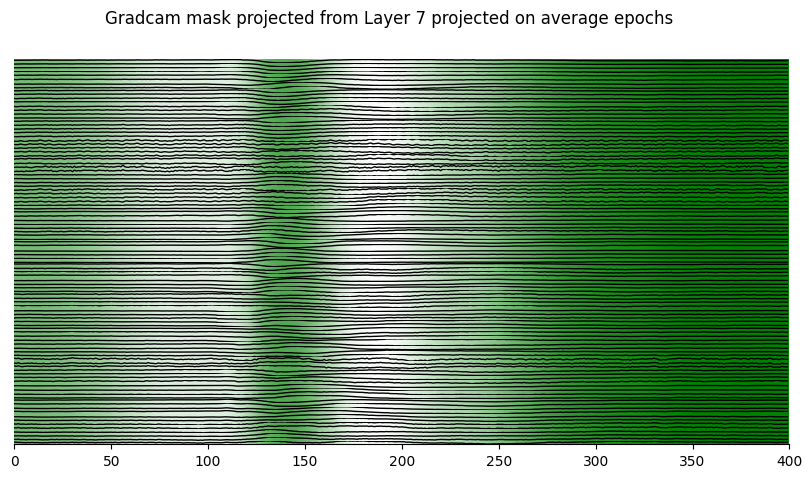

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


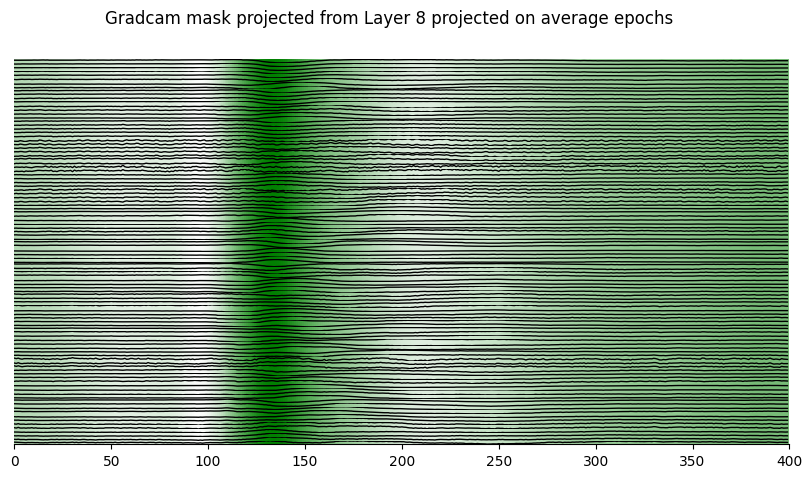

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


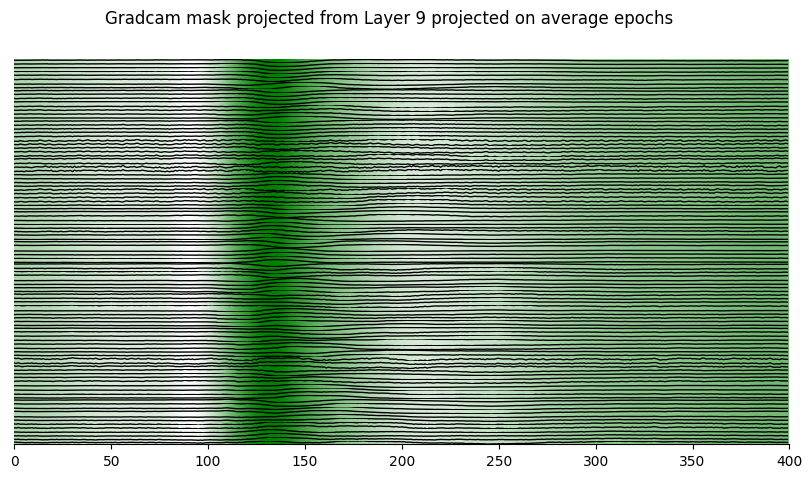

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


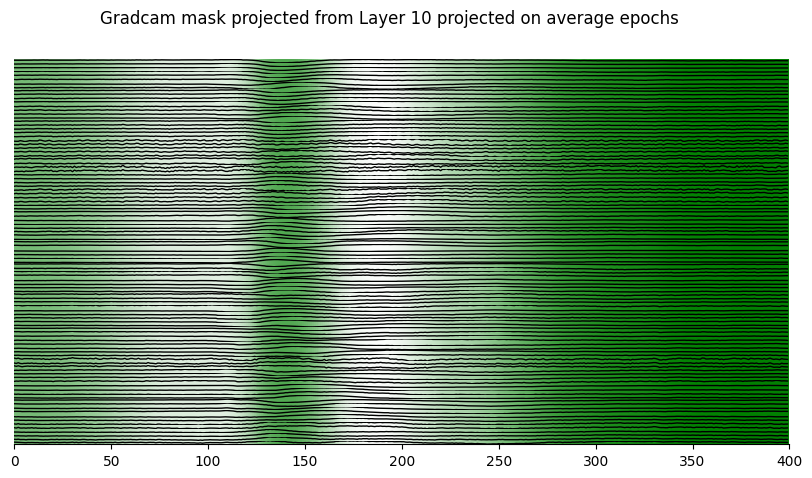

Length of label vector different from number of data samples for subject CC210051. Skipping.
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:988: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


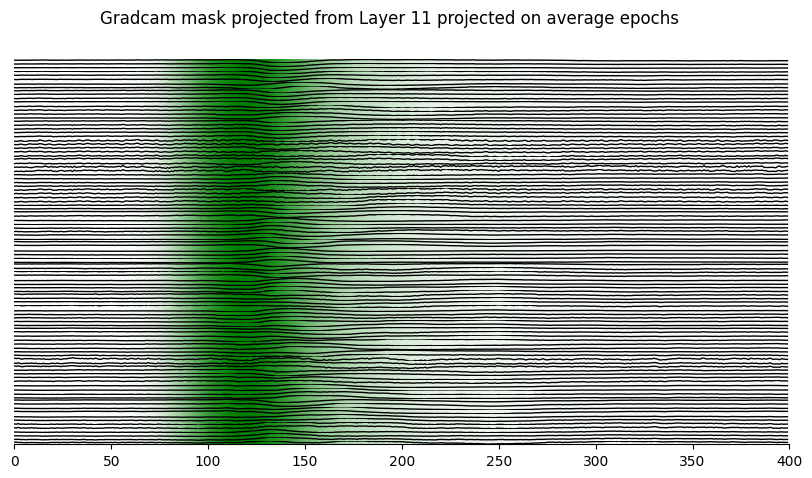

In [5]:
sfreq = 500
n_samples = None
lso = True
n_sub = len(subj_list)

for i, layer in enumerate(net.feature_extraction):
    if type(layer) is Flatten:
        break
        
    target_layers = [layer]
    gradcam = GradCAM(model=net, target_layers=target_layers)

    all_cams = []
    all_trials = None
    for sub in subj_list:
        dataset = Dataset(
            sfreq=sfreq,
            n_subjects=max_subj,
            n_samples=n_samples,
            sensortype=sensors,
            lso=lso,
            random_state=seed,
        )
        dataset.load(save_path, one_sub=sub, verbose=0)
        data = dataset.data
        if data == []:
            continue
        input_tensor = data.to(torch.float)  # can be multiple images

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = gradcam(input_tensor=input_tensor, targets=None)

        # In this example grayscale_cam has only one image in the batch:
        all_cams.append(np.mean(grayscale_cam, 0))
        if all_trials is None:
            all_trials = data.mean(axis=0)[0] / n_sub
        else:
            all_trials += data.mean(axis=0)[0] / n_sub

    all_cams = np.array(all_cams)
    cams = np.mean(all_cams, axis=0)
    cams_img = cv2.merge([cams, cams, cams])

    img = Image.fromarray(np.uint8(255 * cams_img))
    # img.save(os.path.join(viz_path, f"gradcam_masklayer{i}.png"))

    fig, _ = plot_masked_epoch(all_trials, cams)
    fig.suptitle(f"Gradcam mask projected from Layer {i+1} projected on average epochs")
    plt.show()
    # plt.savefig(os.path.join(viz_path, f"average_trial_layer{i}.png"), dpi=400)
